# Bookchapter Tutorial

This notebook contains code for the examples from the bookchapter "Developing complex RNA design applications in the Infrared framework"
by Hua-Ting Yao, Yann Ponty, and Sebastian Will.

The main purpose of this notebook is to allow readers of the chapter to easily run examples and possibly experiment with the code. Code is therefore given in the same order as in the bookchapter and under corresponding section titles.

Compared to the code given in the chapter, we extended some code to make it even more illustrative, e.g. by plotting results. Finally, we provide code to generate figures of the bookchapter in the Appendix.


## 1 Introduction

In [1]:
from infrared import *
from infrared.rna import *

import matplotlib.pyplot as plt

In [2]:
target = "((((((((((...))))((((....))))))))))"
model = Model(len(target), 4)
model.add_constraints(BPComp(i,j) for (i,j) in parse(target))
sampler = Sampler(model)
samples = [sampler.sample() for _ in range(10)]

In [3]:
sequences = [ass_to_seq(x) for x in samples]
sequences

['GGUAUGUCUGGCGCGGGACGUGUUAACGUUAUACC',
 'CUCCGGGAUGAUACGUUCCUGAGUGUGGGUUGGAG',
 'UUCAGGCGAUUCUGUUGGUAGACUCUUACCUUGGA',
 'CAUACGAGGAACCUCUUUAUAAAUUUAUGCGUGUG',
 'CAGUUAAGUCAAAGGUUUAGGAAGCUUUGUAAUUG',
 'UGCGGAAUUGCUGCAAUUUAGUGUGCUAAUUUGUG',
 'ACGAUGGUGCUGAGCGCGCGAGGCCUCGCUGUCGU',
 'AGUAUGUCUUGCGAGGAGGGUGUACACCUCGUGCU',
 'GGUAGUUCUUUCAGAGAGGGAUUUUUCCCGCUAUC',
 'AUUCUCCCUGCCUCAGGCGUGGUUUUGCGGAGGGU']

We are going to visualize the nucleotide frequencies of the sampled sequences 
if module ```logomaker``` is availabe.
(e.g. install by ```conda install logomaker```)

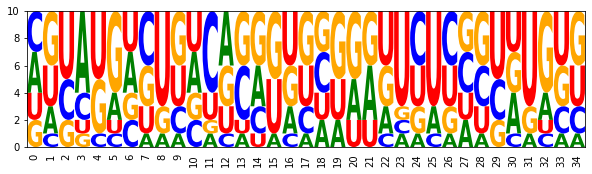

GGUAUGUCUGGCGCGGGACGUGUUAACGUUAUACC
CUCCGGGAUGAUACGUUCCUGAGUGUGGGUUGGAG
UUCAGGCGAUUCUGUUGGUAGACUCUUACCUUGGA
CAUACGAGGAACCUCUUUAUAAAUUUAUGCGUGUG
CAGUUAAGUCAAAGGUUUAGGAAGCUUUGUAAUUG
UGCGGAAUUGCUGCAAUUUAGUGUGCUAAUUUGUG
ACGAUGGUGCUGAGCGCGCGAGGCCUCGCUGUCGU
AGUAUGUCUUGCGAGGAGGGUGUACACCUCGUGCU
GGUAGUUCUUUCAGAGAGGGAUUUUUCCCGCUAUC
AUUCUCCCUGCCUCAGGCGUGGUUUUGCGGAGGGU


In [4]:
def draw_logo(samples,name=None):
    import logomaker as lm
    
    sequences = [ass_to_seq(x) for x in samples]
    
    matrix = lm.alignment_to_matrix(sequences = sequences)
    logo = lm.Logo(matrix)
    logo.style_xticks(rotation=90, fmt='%d', anchor=0)
    logo.ax.xaxis.set_ticks_position('none')
    if name is not None:
        plt.savefig(name)
    plt.show()
    logo.ax.xaxis.set_tick_params(pad=-1)
    return sequences

def opt_draw_logo(samples,name=None,num=10):
    try:
        draw_logo(samples,name)
    except ModuleNotFoundError as e:
        print(e)
    for x in samples[:num]:
        print(ass_to_seq(x))
    if len(samples)>num:
        print("...")

def assignments_to_seqs(xs):
    return [ass_to_seq(x) for x in xs]

opt_draw_logo(samples)

#### Multiple targets

In [5]:
#           01234567890123456789012345678901234
targets = ["((((((((((...))))((((....))))))))))",
           "((((((.((((((((....))))..))))))))))",
           ".((((((...)))))).(((((((....)))))))"]

In [6]:
for target in targets:
    model.add_constraints(BPComp(i,j) for (i,j) in parse(target))

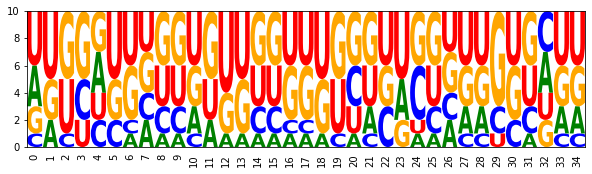

UUCCCCAUCUUGGGGAUUUUCUUUCGAGAGGGGGA
CUUCGUGCUCCGUGGGCUUUCGCUGGGAGGUGAGG
AAGGAGUGAAAUUUUUGAAGAGGAUUUUUCUUCUU
UUUUCUGUUUUGGAGGUUUUUCCUGAAGAGGGAAA
AGGGGGUAGGGUUUUUGGGGGGGGAUUUUUCUUUU
GAGGAUCAGGGAUUUUGGGGGAUACCUUUGUCUUU
UUUCAUGUUUUAUGAGUUUUCAUUGGGAGGUGAGG
UUUUUCGCCCUGGGGGUCUCUUUUCGGGGGGAGAG
AGGGUGUGGGGUAUCCGGGGGUGACCCUUCGCCCU
GGGGGUUGGGAGUUCCAGGGGGCGGUCCCGCUCUC


In [7]:
sampler = Sampler(model)
designs = [sampler.sample() for _ in range(10)]

samples = [x for x in designs]
opt_draw_logo(samples)

## 3 Methods

### 3.1 Elementary use of Infrared - A simple design model

In [8]:
n = 35

In [9]:
model = Model(n,4)

In [10]:
target = "((((((((((...))))((((....))))))))))"
model.add_constraints(BPComp(i,j) for (i,j) in parse(target))

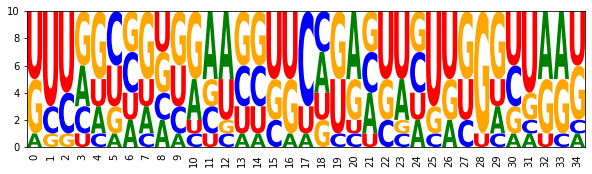

UUCCGCGUGGACUCCGUCUCCAGUUGGGGGCGGAG
GCUGGCCGAUUGAGUUGCAGGCUGUUUUGGCCAGU
GUUAGUUGCAGAAUGUGCAGAAUAGUUUGGCUAAU
GUCAAAAAGGCAGCCUUCGUACGCGUACGUUUGAU
UCUGUCGGAUAGUGUCUUUGAGUUAUUGGGAUGGG
AUGUUCCGCCGAUGGCGACUUGGAAGGGUGGAUGU
UUCGGUCGUUGUAAAUGCGUAUUUGUACGAUUGAG
UGUGAUUUUGGAACGGACCUGCCACCGGGAUUACA
GUUCGGGCGCGCAGCGUUAGGACUCUUUGCUGAGC
UUUACGAAUGAACUGUUCCGAGUUCUUGGUGUAAG


In [11]:
sampler = Sampler(model)
samples = [sampler.sample() for _ in range(10)]

opt_draw_logo(samples)

### 3.2 Sequence constraints in IUPAC code

In [12]:
iupac_sequence = "SNNNNNNNNNRYYNNNNNNNNGNRANNNNNNNNNS"

In [13]:
for i, x in enumerate(iupac_sequence):
    model.add_constraints(ValueIn(i, iupacvalues(x)))

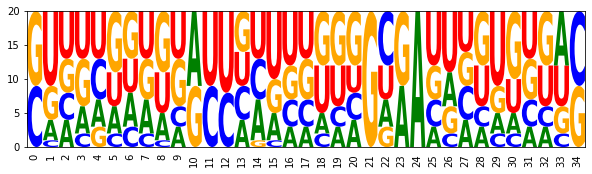

CGUUCAAUUGAUUCAAUUCGGGUGACUGGUGAAUG
GGGGCCAUUAGUCUAAUUGCGGCGAUGCAGGUCUC
CAGCGGGGAGAUUUUCUGUGGGCAAUUGCUUGUUG
GGUACCUCGUACUGUGAGGCCGCAAGGCCGGUGCC
GUCCAAGUUUGUCGAGUGGUGGUGACAUUUUGGAC
GUCUUUUUACAUCGUGGUGUAGAGAUACGGGGGAC
GAUGUGCAUGGCCCAUGGUGUGGAAAUACUACAUC
GUGUUGGAUUACUAAUCUUGUGAGAAUGAUGGUAC
CUCAAACCGCGUUGCGGAAGGGCGACCUUUUUGAG
CUAGAGAUUGGCUCAGUAUUGGCGACAAUUUUUGG
...


In [14]:
sampler = Sampler(model)
samples = [sampler.sample() for _ in range(20)]

opt_draw_logo(samples)

### 3.3 Control of GC content

In [15]:
# add functions for GC control
model.add_functions([GCCont(i) for i in range(n)], 'gc')

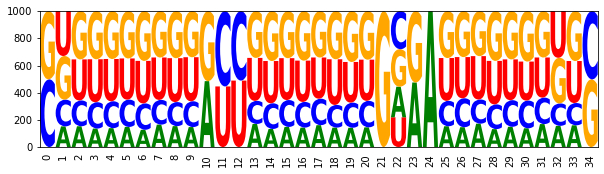

CCGGCUUACUGUUAGUGGAUCGUGAGAUUAGUCGG
GCGUCACUGGAUCUUAGCUAGGAAACUGGUGAUGC
GGUGAACCGGAUCCUGGCCAUGUGAAUGGUUUGUC
CCUCGUUAUUGCCGGUAGAAGGCAACUUUAUGGGG
GGGUGUACGUAUUGUGUGUUAGAAAUAGCACACCC
GGUGGGUGCGACCCGUAGUUUGUAAAGAUCCCACC
CGCUUUGUGCGCCGCGUCCUCGAGAGAGGAGAGUG
GUUUCCUAGAGCUUUUGUCCCGAAAGGGAGGAGAC
GGACCCGUAGGUCCUAUGGUUGGGAAGCUGGGUUC
CGUGUGGUGUGUCGCGUCUCCGCAAGGGGUGCGCG
...


In [16]:
# set a weight and sample
model.set_feature_weight(0.15, 'gc')

sampler = Sampler(model)
samples = [sampler.sample() for _ in range(1000)]
opt_draw_logo(samples)

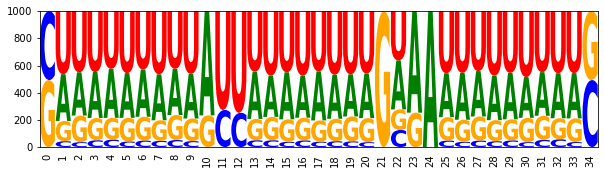

GUUUUAUUAUAUCAUAGCUAAGUGAUUGGUAAAAC
CAUUUUUUGGGCCUUGAUAUUGAGAAGUAAAAAUG
GAUAGGAUGAAUUUUAUAUUAGGAAUAGUUCUAUC
GCAUUAUAAAAUCUUUAUAGUGUAAAUUAUAAUGC
CUUAAGAAGCAUUGUUUUAUUGCAAAAUAUUUGAG
CUUUUGAAUAAUUUAUUAUUUGAAAAAGUCAAAGG
CAAAGAGUUUAUCAGAUAUUAGAAAUGAUUCUUUG
CUAGUGAUUUAUCAAAUUUUUGAGAGAAAUAUUAG
GAAAAAAAUUAUUAAUUAUUUGUGAAAAUUUUUUC
GGGAAAUUGUAUUGUAAUUUUGUAAAAAAUUUCUC
...


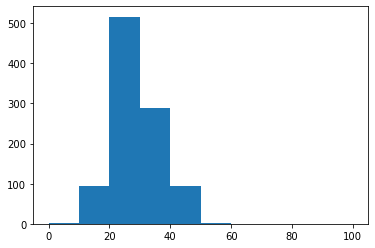

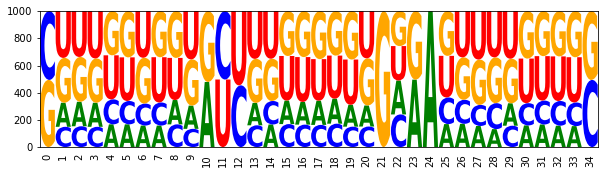

GAGCGUGCUUGUCGAGUGACUGAAAAGUUGUGCUC
GCUGUAGCGAGCCUCGUGAGUGUGAAUUCUGCAGC
GUUGUCUUUUACCGAGGCUGGGCAAUCAGGGCAGC
GGGUCUCUAAAUCUUAGGAUGGAAACAUCAGAUCC
CCAAGGGGGGGCCUCUUUCUCGGGAGAGGUCUUGG
GCUGGGCUCGACUUGAGUUUGGUAAUGAACCCAGC
CUAUUGUGUUACCAACGAUUGGAGACGGUUGAUGG
CUUUAGGGUCGUCGAUUUCUUGGAAGGGGUUGGAG
CGUUGGGGAAAUCUUCUCAUGGAGACGUGUCGGUG
GUCGUCGUGUACCGCACGGAUGCGAAUUUGGCGGC
...


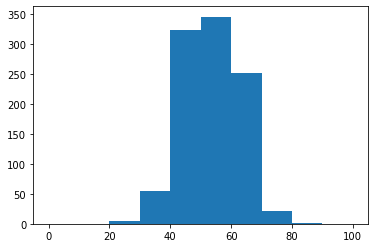

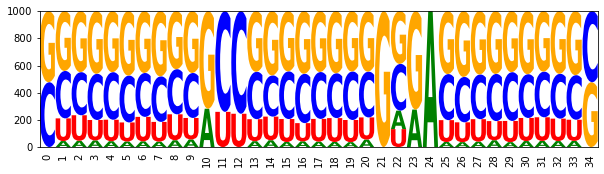

GCUGGGGCCUGCCAGGCAGUGGGGACACUCCUAGC
GGCUCCGGUGACCCGCUUUAGGAGACUGAGGAGCC
CAGGGCUGCCGCCGGCGGGCCGCGAGGCCGCCCUG
CCGCGACGCGGCUCGCGCUUCGUGAGAGGUCGCGG
CCGCGCGUUCGCUGGGCUAGCGGGAGCUGGCGCGG
GGCUGCGGCCGCCGGCUGCGAGGGAUCGUGCGGCC
CCGCCUGCGCGCCGCGCGGGGGGGAUCCCGGGCGG
CGGUGCCGUGGUCCACGCCCCGUAAGGGGGCGCCG
GCCUGGCGGAACCUCCGCCGGGCAACUGGUCGGGC
CCGUGCUCGGACCCCGAUCGGGUGACUGGGUGCGG
...


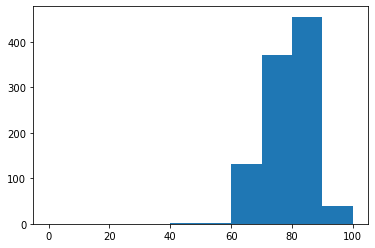

In [17]:
## Code to produce the figures in the paper
WRITEFIGS = False
for name,weight in [('minus', -1), ('zero', 0), ('plus', 1)]:
    
    model.set_feature_weight(weight, 'gc')
    sampler = Sampler(model)
    samples = [sampler.sample() for _ in range(1000)]

    opt_draw_logo(samples, f"gc_content_{name}-logo.svg")
    sequences = assignments_to_seqs(samples)

    gc_contents = [100*sum(x in "GC" for x in sequence)/len(sequence) for sequence in sequences]
    h = plt.hist(gc_contents,bins=10,range=(0,100))
    if WRITEFIGS:
        plt.savefig(f"gc_content_{name}-hist.svg")

Set a target of 75% GC content and then draw targeted samples

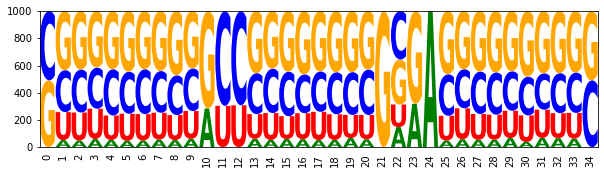

GCGGCGGGUCGCUGGCCUGGGGAGACUCACGUUGC
GCGACGGGGGGCCUCUCGUUGGCGACAACCGUCGC
GGCUGUGGCCGCCGGUCGCGAGGGAUUGUGCGGUC
CGGGGGGGGCGCUGCCUGCUGGUAACAGCCCUCUG
CCCUGUCCGGGCUCUGGGACAGGGAUGUCGCGGGG
GGGUGGCUGCAUCGCGGUACCGCAAGGUGCCGCCC
GGUGCCGUCCGUCGGGUUGUCGCGAGGCGGGUGUC
CCCGGCGGGUGCCACCUGCAGGUGAUUGCGCUGGG
GAGGGUGGGCAUCGUUCGGGGGCGACUCCGCCCUC
CCUCCUUUUGGCUUGGACGCCGCGAGGCGGGGGGG
...
GC content in samples: 74.29%


In [18]:
sampler = Sampler(model)

sampler.set_target( 0.75 * n, 0.01 * n, 'gc' )

samples = [sampler.targeted_sample() for _ in range(1000)]
opt_draw_logo(samples)
sequences = assignments_to_seqs(samples)

gc_contents = [100*sum(x in "GC" for x in sequence)/len(sequence) for sequence in sequences]
gc_content = sum(gc_contents) / len(gc_contents)
print(f"GC content in samples: {gc_content:0.2f}%")

### 3.4 Controlling energy - Multiple features

In [19]:
# recall current model
model = Model(n,4) 
bps = parse(target)
model.add_constraints(BPComp(i,j) for (i,j) in bps)
model.add_functions([GCCont(i) for i in range(n)], 'gc')

In [20]:
# add (base pair) energy control
model.add_functions([BPEnergy(i, j, (i-1, j+1) not in bps)
                     for (i,j) in bps], 'energy')

In [21]:
# target specific GC and low energy 
model.set_feature_weight(-2, 'energy')
sampler = Sampler(model)
sampler.set_target(0.75*n, 0.01*n, 'gc')
samples = [sampler.targeted_sample() for _ in range(10)]

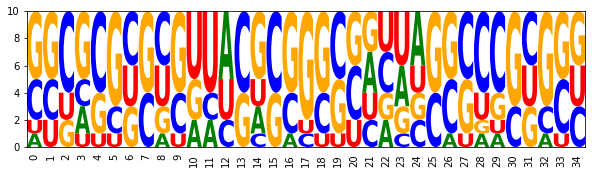

GCCUCGUCUCAACGAGGGCCCGUACGGGCCGGGGU
UUUCCGCGGCGAAGCCGGGUGGGGACACCCGGAGG
GGCGGCUGCGUUUCGCAGGCGUGUUCGCCGCCGCU
CGCCCGGGUGGUUCGCCGCCUUCUAGGGCUGGGUG
CCUGUGCCCCUUAGGGGGGGUACCUGCCUCGCGGG
GUCAGCUCGUUCAGUGGGGGCCCGGGCUCGCUGGC
CGCGGGGCUGUUUCAGCGCCGGUUACGGUCCCGCG
GCGGCUCGCGGUACGCGGUGCAAACGCGCAGUCGC
GGGACGCGAGAUCCUCGCGGGAUAGCCCGCGUCCC
AGCGCGGGCGUCACGCCUGCCCAUAGGCACGCGCU


In [22]:
opt_draw_logo(samples)

In [23]:
# add stacking energy control 
# - this could be used in place of defining base pair energy
#   in the code above
model.add_functions([StackEnergy(i, j)
    for (i,j) in bps if (i+1,j-1) in bps], 'energy')

### 3.5 Targeting Turner energy - Customized features

*Note:* From this point on, we require RNA energy evaluation based on the Vienna RNA library. Under Mac and Linux, the functionality is accessed via module RNA of the library. Since, this is typically unavailable on Windows, we provide a work around.

In [24]:
try:
    from RNA import energy_of_struct
except:
    print("*Warning*: the RNA Python bindings cannot be imported.\n\n"
          "For Linux and MaxOS it is recommened to install viennarna via conda. "
          "Windows users are asked to install the Vienna package using the provided Windows installer "
          "and make sure that the command line tool RNAeval is found based on their search path."
         )
    def energy_of_struct(seq,struct):
        try:
            import subprocess
            import re
            p = subprocess.run(["RNAeval"], input=f"{seq}\n{struct}".encode('utf-8'), capture_output=True)
            m = re.search(r'([0-9-.]*)\)$',p.stdout.decode('utf-8').split('\n')[1])
            res = float(m[1])
        except Exception as e:
            print(f"Cannot evaluate energy of {seq}, {struct}")
            raise e
        return res

In [25]:
# Restate current model
model = Model(n,4) 
bps = parse(target)
model.add_constraints(BPComp(i,j) for (i,j) in bps)
model.add_functions([GCCont(i) for i in range(n)], 'gc')
model.add_functions([BPEnergy(i, j, (i-1, j+1) not in bps)
                     for (i,j) in bps], 'energy')

In [26]:
# add the Turner energy feature
model.add_feature('Energy', 'energy',
    lambda sample, target=target:
        energy_of_struct(ass_to_seq(sample), target))

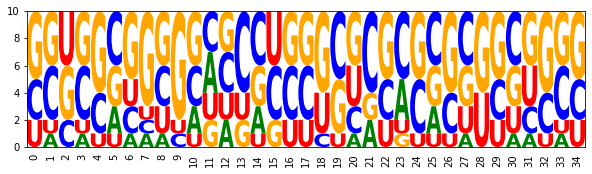

GCGCGCGACGCUCUGUCGGCAAGCGUGUUGCGUGC
UCUGGUGGGGAUUCCUCCGCCGGACGGCGGCUGGG
GCUGUCAGGGCCCCCCUGGUGCUCGCGCUGACGGU
CUGCCGGGUGUCGCACUCGCUCGACAGUGCGGCAG
CGGGGACCCGGGACGGGUGGGCUCUCCCGUUUCCG
UCGGGCUGCGGAGUGUGGGCGAGCCCGCUGCCCGG
GGUUCGUGAGGAACUCGGCCCGCCGGGGUCGAGCU
CGCAGCGUGUCGGGCGCUUGGCCACCUAGGCUGCG
GGCCGGGGUCGACGAUCCUGUCCUGGCGGCUGGCC
GAUCCACGGGACUCCCGCUGUCGGGACGGUGGGUC


[('GCGCGCGACGCUCUGUCGGCAAGCGUGUUGCGUGC', -9.699999809265137),
 ('UCUGGUGGGGAUUCCUCCGCCGGACGGCGGCUGGG', -9.899999618530273),
 ('GCUGUCAGGGCCCCCCUGGUGCUCGCGCUGACGGU', -10.399999618530273),
 ('CUGCCGGGUGUCGCACUCGCUCGACAGUGCGGCAG', -10.300000190734863),
 ('CGGGGACCCGGGACGGGUGGGCUCUCCCGUUUCCG', -10.199999809265137),
 ('UCGGGCUGCGGAGUGUGGGCGAGCCCGCUGCCCGG', -10.300000190734863),
 ('GGUUCGUGAGGAACUCGGCCCGCCGGGGUCGAGCU', -10.5),
 ('CGCAGCGUGUCGGGCGCUUGGCCACCUAGGCUGCG', -9.600000381469727),
 ('GGCCGGGGUCGACGAUCCUGUCCUGGCGGCUGGCC', -10.5),
 ('GAUCCACGGGACUCCCGCUGUCGGGACGGUGGGUC', -10.300000190734863)]

In [27]:
# specify targets and draw targeted samples
sampler = Sampler(model)
sampler.set_target(0.75*n, 0.05*n, 'gc')
sampler.set_target(-10, 0.5, 'Energy')
samples = [sampler.targeted_sample() for _ in range(10)]

opt_draw_logo(samples)
sequences = assignments_to_seqs(samples)

[(seq,energy_of_struct(seq,target)) for seq in sequences]

### 3.6 Multiple target targets

In [28]:
# construct model
model = Model(n,4) 
model.add_functions([GCCont(i) for i in range(n)], 'gc')

for k, target in enumerate(targets):
    bps = parse(target)
    model.add_constraints(BPComp(i,j) for (i,j) in bps)
    model.add_functions([BPEnergy(i, j, (i-1, j+1) not in bps)
                         for (i,j) in bps], f'energy{k}')

#### Target specific GC content and high affinity to all targets

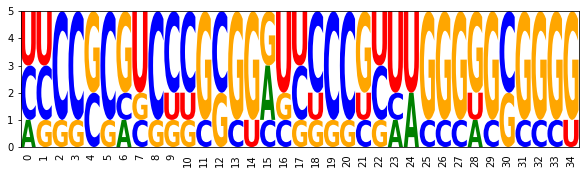

UCCCGCGUCCCGCGGGCUCCCGUUAGGGAGCGGGG
AGGGCCCGGGGGGCUCGGGGGCUAUCCCUGGCCCU
UUCCGGGUCCCCCGGAUCCCCGGUAGGGGCCGGGG
CUCCGCGUCUCGCGGAUCUCCGCCUGGGGGCGGGG
CCCCCCACCCUGGGGGUUCCCUCUUGGGGGGGGGG


['UCCCGCGUCCCGCGGGCUCCCGUUAGGGAGCGGGG -17.7 -21.5 -18.0',
 'AGGGCCCGGGGGGCUCGGGGGCUAUCCCUGGCCCU -15.1 -20.1 -19.4',
 'UUCCGGGUCCCCCGGAUCCCCGGUAGGGGCCGGGG -14.3 -19.4 -22.8',
 'CUCCGCGUCUCGCGGAUCUCCGCCUGGGGGCGGGG -12.1 -18.3 -20.3',
 'CCCCCCACCCUGGGGGUUCCCUCUUGGGGGGGGGG -19.9 -24.2 -18.5']

In [29]:
# set weights for energy targets
for k,_ in enumerate(targets):
    model.set_feature_weight(-2, f'energy{k}')

# create sampler and set target
sampler = Sampler(model)
sampler.set_target(0.75*n, 0.05*n, 'gc')
samples = [sampler.targeted_sample() for _ in range(5)]

opt_draw_logo(samples)
sequences = assignments_to_seqs(samples)

# annotate sequences with energies (annotate with Turner energies only if RNA module is available)
try:
    import RNA
    sequences = ["".join([seq]+[f" {energy_of_struct(seq,target):5.1f}" for target in targets]) for seq in sequences]
except ModuleNotFoundError:
    pass

sequences

#### Target specific GC content and specific Turner energies for all targets

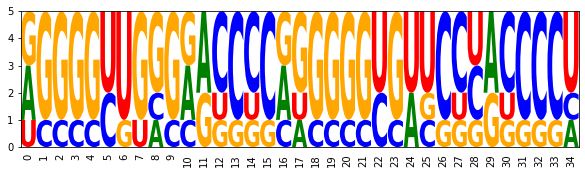

GGGGGCUGAGGGCCUCAAGGGGCGACCUUGCCCCU
GGGGGUUGGGAACCCCGGGGGGUGUUCCUACCCCC
AGGGGCUGGGAGUCCCAGGGGGCGAUCCCGUCCCU
AGGGGUUGGGGACCCCGGGGGGUGUUCCCACCCCU
UCCCCUGUCCCAGGGGCUCCCCUCUGGGGAGGGGA


['GGGGGCUGAGGGCCUCAAGGGGCGACCUUGCCCCU -14.7 -19.8 -19.4',
 'GGGGGUUGGGAACCCCGGGGGGUGUUCCUACCCCC -14.3 -20.8 -19.8',
 'AGGGGCUGGGAGUCCCAGGGGGCGAUCCCGUCCCU -15.7 -19.2 -19.1',
 'AGGGGUUGGGGACCCCGGGGGGUGUUCCCACCCCU -14.7 -20.5 -20.5',
 'UCCCCUGUCCCAGGGGCUCCCCUCUGGGGAGGGGA -14.9 -20.8 -21.0']

In [30]:
# add Turner energy features for all target targets
for k, target in enumerate(targets):
    model.add_feature(f'Energy{k}', f'energy{k}',
        lambda sample, target=target:
            energy_of_struct(ass_to_seq(sample), target))

sampler = Sampler(model)
sampler.set_target(0.75*n, 0.01*n, 'gc')

sampler.set_target( -15, 1, 'Energy0')
sampler.set_target( -20, 1, 'Energy1')
sampler.set_target( -20, 1, 'Energy2')

samples = [sampler.targeted_sample() for _ in range(5)]

opt_draw_logo(samples)
sequences = assignments_to_seqs(samples)

# annotate sequences with energies
["".join([seq]+[f" {energy_of_struct(seq,target):5.1f}" for target in targets]) for seq in sequences]

### Plot dependencies and tree decomposition

In [31]:
from IPython.display import Image

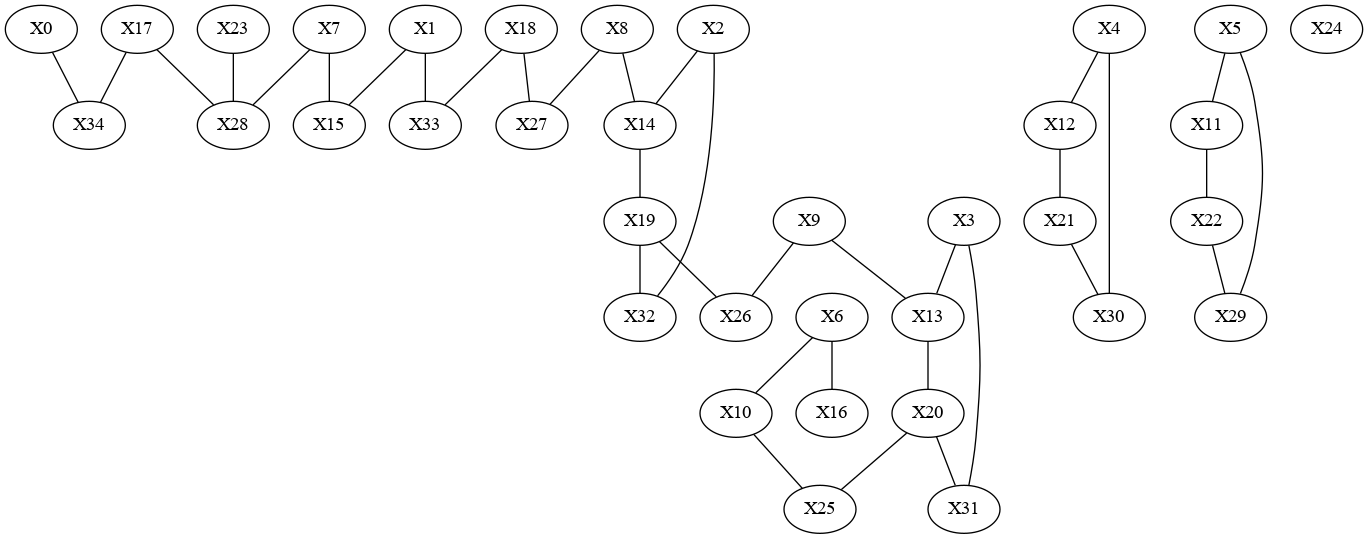

In [32]:
# Plot dependency graph

filename = 'dependency_graph.dot'
model.write_graph(filename, True)

dotfile_to_png(filename)
dotfile_to_pdf(filename)

filename = re.sub(r"dot$","png",filename)

Image(filename=filename,width=600)

Tree width: 2


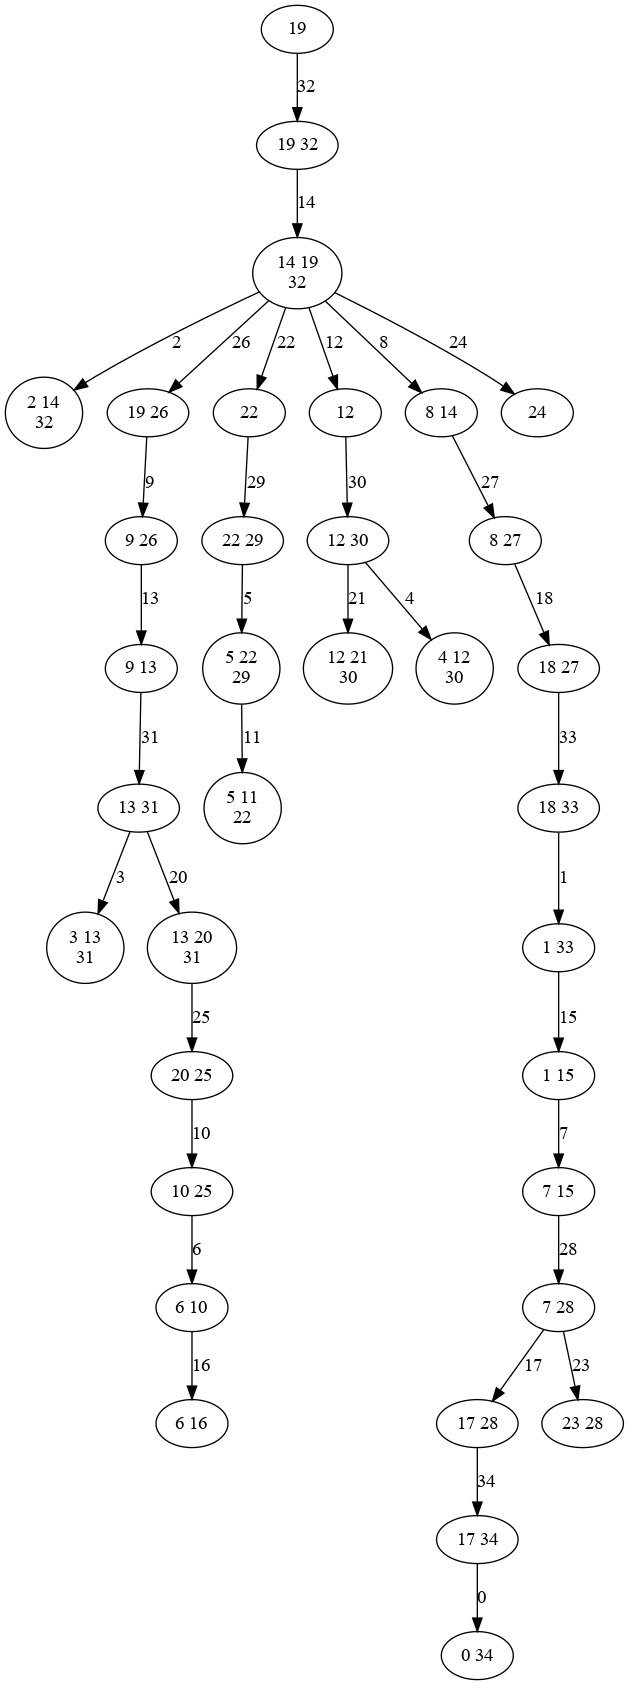

In [33]:
# Plot tree decomposition
sampler = Sampler(model)
print(f"Tree width: {sampler.treewidth()}")
filename="treedecomp"
sampler.plot_td(filename,'png')
sampler.plot_td(filename,'pdf')
sampler.plot_td(filename+".dot",'dot')
Image(filename=filename+".png",width=300)

### 3.7 Negative design by sampling

In [34]:
target = targets[0]
n = len(target)

In [35]:
def is_mfe_design(sequence, target):
    fc = RNA.fold_compound(sequence)
    return fc.eval_structure(target) == fc.mfe()[1]

In [36]:
def single_target_design_model(target):
    n, bps = len(target), parse(target)
    model = Model(n, 4)
    model.add_constraints(BPComp(i, j) for (i, j) in bps)
    model.add_functions([GCCont(i) for i in range(n)], 'gc')
    model.add_functions([BPEnergy(i, j, (i-1, j+1) not in bps)
        for (i,j) in bps], 'energy')
    model.set_feature_weight(-1.5, 'energy')
    return model

In [37]:
# solve by direct sampling
sampler = Sampler(single_target_design_model(target))
sampler.set_target(0.7 * n, 0.1 * n, 'gc')
for i in range(50):
    seq = ass_to_seq(sampler.targeted_sample())
    if is_mfe_design(seq,target):
        print(f"{i} {seq}")

1 CGCGGGGCCGGUGCGGCCGAUUGAUGUCGCCCGCG
13 GGUCUUGGCCAAUGGCCUCCGACAUCGGAAAGGCC
18 GGUGCGGCCCCUCGGGCGUGCUACAGCACUGCGCU
22 GGUCGCGCGUACAACGCUGCCAAUAGGCGGCGACC
26 AGGGCGGCGCGUAGCGCGCCGUCAUCGGCCGCUCU
28 GCCACGGGCUCUCGGUCCCCGCCAACGGGCGUGGC
36 GGCCCCCCGUAUCGCGGAGCCUUCUGGCUGGGGCC


In [38]:
def target_frequency(sequence, target):
    fc = RNA.fold_compound(sequence)
    fc.pf()
    return fc.pr_structure(target)

In [39]:
sampler = Sampler(single_target_design_model(target))
sampler.set_target(0.7 * n, 0.1 * n, 'gc')
best = 0
for i in range(100):
    seq = ass_to_seq(sampler.targeted_sample())
    freq = target_frequency(seq,target)
    if freq > best:
        best = freq
        print(f"{i} {seq} {freq:.6f}")

0 GGCUCGGCGCUGGGCGCGCCGAUCACGGCUGAGCC 0.402200
4 GGGCGCGCCGUGACGGCGGGCAAGUGCCUGUGCCC 0.751976
13 GGCGCGAGGUGCAGCCUGGAGGAUACUCCCGUGCC 0.763548
30 GCCAGCGCUCUAGGAGCCCGCACAUGUGGGCUGGC 0.936292


### 3.8 Larger single-target designs by constraint generation

RNAPOND-like negative design (generating constraints for disruptive base pairs).

In [40]:
from collections import Counter

## A hard instance, eterna37
# target = "(((((.((((((.((((((.((((((.((((((.((((((....((((((......)))))).)))))).(((((...(((((((...)))))))))))).)))))).((((((((((((...)))))))...))))).))))))....))))))....))))))....)))))"

## a slightly harder instance
target = "..(((..((((.....)))).((...(((.....)))...))...))).."

n = len(target)
bps = parse(target)

In [41]:
def cg_design_iteration():
    model = single_target_design_model(target)
    model.add_constraints(NotBPComp(i, j) for (i, j) in dbps)
    sampler = Sampler(model, lazy=True)
    if sampler.treewidth() > 10 or not sampler.is_consistent():
        return "Not found"
    ctr = Counter()
    found, sol = False, None
    for i in range(100):
        seq = ass_to_seq(sampler.targeted_sample())
        fc = RNA.fold_compound(seq)
        mfe, mfe_e = fc.mfe()
        if fc.eval_structure(target) == mfe_e:
            sol = seq
        ctr.update(parse(mfe))
    ndbps = [x[0] for x in ctr.most_common() if x[0] not in bps]
    dbps.extend(ndbps[:2])
    return sol
i=0
dbps, seq = [], None
while seq is None:
    i += 1
    seq = cg_design_iteration()
print(i,seq)

2 UUCGCCCUCGGUAUCCCCGAUCCUACACCUACUUGGUCCUGGUUCGCGUC


### 3.9 Negative design by stochastic optimization with partial resampling

In [42]:
## define multi-target design model for resampling of subsets 
def multi_design_model(subset=None, solution=None):
    n = len(targets[0])
    model = Model(n, 4)
    if subset is None: subset = set(range(n))
    for i in set(range(n))-subset:
        value = solution.values()[i]
        model.restrict_domains(i,(value,value))
    model.add_functions([GCCont(i) for i in subset], 'gc')
    for target in targets:
        s = parse(target)
        ss = [(i,j) for (i,j) in s if i in subset or j in subset]
        model.add_constraints(BPComp(i, j) for (i, j) in ss)
        model.add_functions([BPEnergy(i, j, (i-1, j+1) not in s)
            for (i,j) in ss], 'energy')
    model.set_feature_weight(-0.8, 'energy')
    model.set_feature_weight(-0.3, 'gc')
    return model

In [43]:
def multi_defect(sequence, targets, xi=1):
    k = len(targets)
    fc = RNA.fold_compound(sequence)
    ee = fc.pf()[1]
    eos = [fc.eval_structure(target) for target in targets]
    diff_ee = sum(1/k * (eos[i] - ee) for i in range(k))
    diff_targets = sum(2/(k*(k-1)) * abs(eos[i]-eos[j])
        for i in range(k) for j in range(k) if i<j)
    return diff_ee + xi * diff_targets

In [44]:
from random import random, choices
from math import exp

In [45]:
# Return the sequence achieving the best defect within optimization
def multi_design_optimize(steps, temp):
    cc, cur, curval, bestval = None, None, math.inf, math.inf
    for i in range(steps):
        model = multi_design_model(cc, cur)
        new = Sampler(model).sample()
        newval = multi_defect(ass_to_seq(new),targets,1)
        if (newval <= curval
            or random() <= exp(-(newval-curval)/temp)):
            cur, curval = new, newval
            if curval < bestval:
                best, bestval = cur, curval
        if i==0:
            ccs = model.connected_components()
            weights = [1/len(cc) for cc in ccs]
        cc = choices(ccs,weights)[0]
    return (ass_to_seq(best), bestval)

In [46]:
multi_design_optimize(1000,0.015)

('CUCCGAGCUCCUUGGGCCCCCGAUAGGGGUCGGGG', 1.7400503158569336)

### 3.10 A real world example: design of a Tandem-Riboswitch

In [47]:
seqTheo0 = "AAGUGAUACCAGCAUCGUCUUGAUGCCCUUGGCAGCACUUCAGAAAUCUC"\
           "UGAAGUGCUGUUUUUUUU"
seqTet0  = "GGCCUAAAACAUACCAGAGAAAUCUGGAGAGGUGAAGAAUACGACCACCU"\
           "AGGCCGACAGUGGCCUAGGUGGUCGUUUUUUUUU"

In [48]:
seqTheo  = "NNNNGAUACCAGCAUCGUCUUGAUGCCCUUGGCAGCNNNNNNNNNNNNNN"\
           "NNNNNNNNNNUUUUUUUU"
aptTheo  = "(((((...((((((((.....)))))...)))...))))).........."\
           ".................."
termTheo = "...............................(((((((((((((....))"\
           ")))))))))))......."


seqTet   = "NNNNNAAAACAUACCAGAGAAAUCUGGAGAGGUGAAGAAUACGACCACCU"\
           "ANNNNNNNNNNNNNNNNNNNNNNNNUUUUUUUUU"
termTet  = "........................................(((((((((("\
           "(((((......)))))))))))))))........"
aptTet   = "((((((.......(((((....)))))...((((...........)))))"\
           ")))))............................."

spacerLen = 30

In [49]:
aptamers    = aptTheo  + "."*spacerLen + aptTet
terminators = termTheo + "."*spacerLen + termTet
sequence    = seqTheo  + "N"*spacerLen + seqTet

n = len(aptTheo) + spacerLen + len(aptTet)

In [50]:
variants = dict(
    empty = '.'*n,
    aptTheo = aptTheo + '.'*(n-len(aptTheo)),
    aptTet = '.'*(n-len(aptTet)) + aptTet,
    termTheo = termTheo + '.'*(n-len(aptTheo)),
    termTet = '.'*(n-len(aptTet)) + termTet,
    spacer = '.'*len(aptTheo) + 'x'*spacerLen + '.'*len(aptTet)
)

In [51]:
def constrained_efe(sequence,c):
    fc = RNA.fold_compound(sequence)
    fc.hc_add_from_db(c)
    return fc.pf()[1]

def rstd_objective(sequence):
    efe = {k:constrained_efe(sequence,variants[k]) 
           for k in variants}
        
    term_stability = efe['termTheo'] + efe['termTet'] \
        - 2*efe['empty']
    apt_target = abs(efe['aptTheo']-efe['empty']-7) \
        + abs(efe['aptTet']-efe['empty']-10)
    spacer_unfolding = efe['spacer']-efe['empty']

    return term_stability + apt_target + spacer_unfolding

In [52]:
def rstd_model(subset=None, solution=None):
    rstd_targets = [aptamers, terminators]
    n = len(rstd_targets[0])
    model = Model(n, 4)
    if subset is None: subset = set(range(n))
    for i in set(range(n))-subset:
        value = solution.values()[i]
        model.restrict_domains(i,(value,value))
        
    for i, x in enumerate(sequence):
        model.add_constraints(ValueIn(i, iupacvalues(x)))
        
    model.add_functions([GCCont(i) for i in subset], 'gc')
    for k,target in enumerate(rstd_targets):
        s = parse(target)
        ss = [(i,j) for (i,j) in s if i in subset or j in subset]
        model.add_constraints(BPComp(i, j) for (i, j) in ss)
        model.add_functions([BPEnergy(i, j, (i-1, j+1) not in s)
            for (i,j) in ss], f'energy{k}')
    model.set_feature_weight(-0.6, 'energy0')
    model.set_feature_weight(-1, 'energy1')
    model.set_feature_weight(-0.3, 'gc')
    return model

def rstd_optimize(steps, temp):
    cc, cur, curval, bestval = None, None, math.inf, math.inf
    for i in range(steps):
        model = rstd_model(cc, cur)
        new = Sampler(model).sample()
        newval = rstd_objective(ass_to_seq(new))
        if (newval <= curval
            or random() <= exp(-(newval-curval)/temp)):
            cur, curval = new, newval
            if curval < bestval:
                best, bestval = cur, curval
                #print(ass_to_seq(best),bestval)
        if i==0:
            ccs = model.connected_components()
            weights = [1/len(cc) for cc in ccs]
        cc = choices(ccs,weights)[0]
    return (ass_to_seq(best), bestval)

In [53]:
rstd_optimize(steps = 500, temp = 0.03)

('CGGCGAUACCAGCAUCGUCUUGAUGCCCUUGGCAGCGCCGGACGGUAACGUCUGGCGUUGUUUUUUUUCUUAUUCAAAUGCAAAAAUUGACCCUUCACGUGGUAAAACAUACCAGAGAAAUCUGGAGAGGUGAAGAAUACGACCACCUACUGCAGUGAGGCGGUGGGUGGUUGUUUUUUUUU',
 3.0943984985351562)

##### Run optimzation in parallel

In [55]:
import concurrent.futures

steps = 500
jobs = 12

def my_rstd_optimize(i):
    seed(None)
    return rstd_optimize(steps,0.03)

with concurrent.futures.ProcessPoolExecutor() as executor:
    res = executor.map(my_rstd_optimize, range(jobs))
res = list(res)

In [ ]:
for seq, val in res:
    print(f"{seq} {val:.2f}")
    fc = RNA.fold_compound(seq)
    for k,c in variants.items():
        print(f"{k:20} {fc.eval_structure(c):8.2f} {constrained_efe(seq,c):8.2f} {constrained_efe(seq,c)-constrained_efe(seq,variants['empty']):8.2f}")

## APPENDIX

### Generate RNAPOND figures

In [60]:
from collections import Counter

## a slightly harder instance
target = "..(((..((((.....)))).((...(((.....)))...))...))).."

n = len(target)
bps = parse(target)
steps = 100

In [61]:
import matplotlib.patches as patches
import matplotlib.cm as cm
import numpy as np
import seaborn as sns

tick = list(range(0,n,5))
cmap = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

# Function to draw base pair counts for each sampling
def draw_heatmap(ax, counter, bps, dbps, new_dbps, vmax, steps=steps, cbar=True):
    # Initial count matrix
    counts = np.zeros((n,n))
    mask = np.tri(counts.shape[0], k=-1)
    for bp, count in counter.items():
        counts[bp[0]][bp[1]] = count
    # Normalization
    counts = counts/steps

    sns.heatmap(counts, vmax=vmax/steps, mask=mask, square=True, cmap=cmap, ax=ax, cbar=cbar)
    for i, j in bps:
        ax.add_patch(patches.Rectangle((j,i), 1, 1, fc="none", ec="blue", lw=1))
    for i, j in dbps:
        ax.add_patch(patches.Rectangle((j,i), 1, 1, fc="none", ec="red", lw=1))
    for i, j in new_dbps:
        ax.add_patch(patches.Rectangle((j,i), 1, 1, fc="none", ec="green", lw=1))

    ax.xaxis.tick_top()
    ax.yaxis.tick_right()
    ax.set_xticks(tick)
    ax.set_xticklabels(tick)
    ax.set_yticks(tick)
    ax.set_yticklabels(tick)

In [62]:
def cg_design_iteration():
    model = single_target_design_model(target)
    model.add_constraints(NotBPComp(i, j) for (i, j) in dbps)
    sampler = Sampler(model, lazy=True)
    if sampler.treewidth() > 10 or not sampler.is_consistent():
        return "Not found"
    ctr = Counter()
    found, sol = False, None
    for i in range(steps):
        seq = ass_to_seq(sampler.targeted_sample())
        fc = RNA.fold_compound(seq)
        mfe, mfe_e = fc.mfe()
        if fc.eval_structure(target) == mfe_e:
            found, sol = True, seq
        ctr.update(parse(mfe))
    ndbps = [x[0] for x in ctr.most_common() if x[0] not in bps]
    dbps.extend(ndbps[:2])
    if found:
        records.append((ctr, dbps[:], []))
    else:
        records.append((ctr, dbps[:], ndbps[:2]))
    return found, sol

# One can use seed() provided by infrared to reproduce the result
seed(1000)
found, records, dbps, seq = False, [], [], None
while not found: found, seq = cg_design_iteration()
print(seq)

CCGACCACCGAAAUGAUCGGCGCUCCCGCUAGAUGUGCUUGCUUAGUCAG


In [63]:
to_draw = [records[i] for i in [0, 1, -1]]
vmax = max(map(lambda t: max(t[0].values()), to_draw))

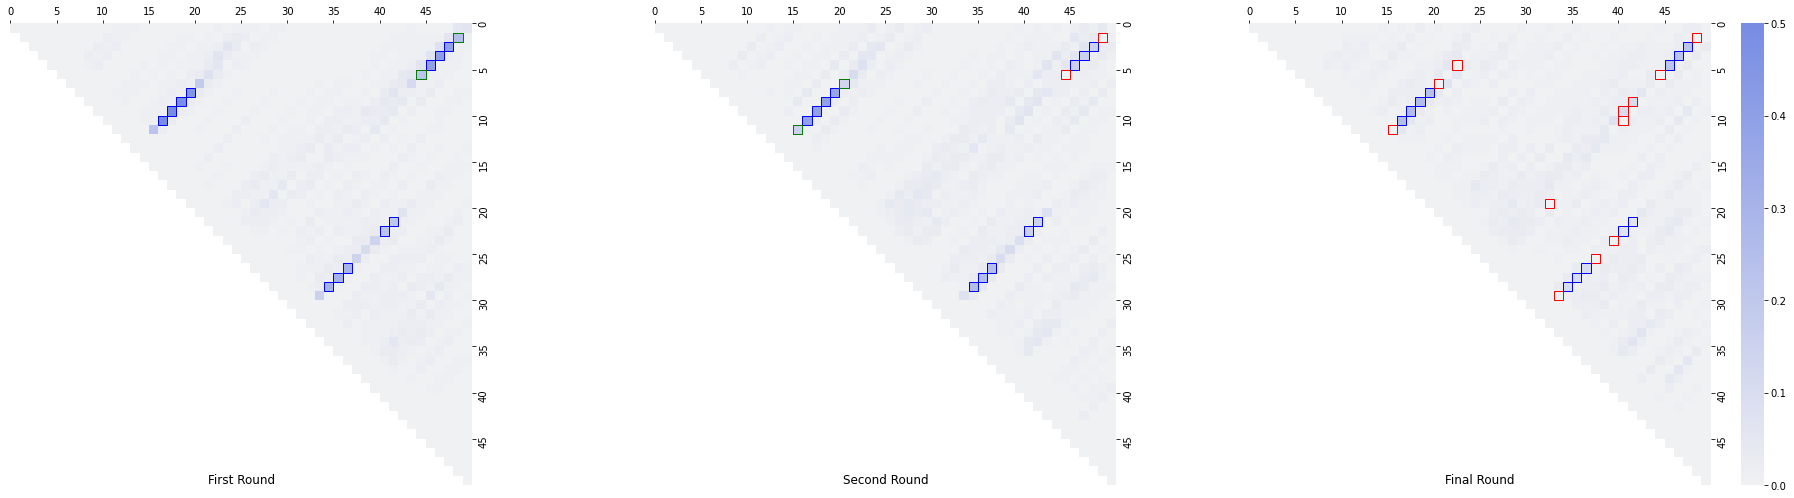

In [64]:
fig, axs = plt.subplots(1,3, figsize=(27,7))
fig.tight_layout()
for i in range(3):
    ax = axs[i]
    counter, disruptive, new_dbps = to_draw[i]
    draw_heatmap(ax, counter, bps, disruptive, new_dbps, vmax, steps=100, cbar=i==2)

axs[0].set_title('First Round', y=-0.01)
axs[1].set_title('Second Round', y=-0.01)
axs[2].set_title('Final Round', y=-0.01)

plt.savefig('count_matrix.pdf', dpi=200, bbox_inches='tight')
plt.show()

### Generate stochastic optimization figure

In [ ]:
import concurrent.futures

def multi_design_optimize_allsteps(steps, temp):
    res = list()
    cc, cur, curval, bestval = None, None, math.inf, math.inf
    for i in range(steps):
        model = multi_design_model(cc, cur)
        new = Sampler(model).sample()
        newval = multi_defect(ass_to_seq(new),targets,1)
        if (newval <= curval
            or random() <= exp(-(newval-curval)/temp)):
            cur, curval = new, newval
            if curval < bestval:
                best, bestval = cur, curval
        if i==0:
            ccs = model.connected_components()
            weights = [1/len(cc) for cc in ccs]
        cc = choices(ccs,weights)[0]
        
        res.append((ass_to_seq(best),bestval))
    return res

def my_multi_design_optimize_allsteps(i):
    seed(None)
    return multi_design_optimize_allsteps(5120,0.015)
with concurrent.futures.ProcessPoolExecutor() as executor:
    res = executor.map(my_multi_design_optimize_allsteps, range(48))
res = list(res)

In [ ]:
the_steps = [1]+[20*(2**i) for i in range(9)]
res2 = [[r[steps-1][1] for r in res] for steps in the_steps]
#print(res2)
fig, ax = plt.subplots()
box = ax.boxplot(res2,
                 labels=the_steps,
                 patch_artist=True,
                 boxprops=dict(facecolor='lightgrey',linewidth=1.25),
                 medianprops=dict(color='blue', linewidth=1.25)
                )
ax.set_ylabel("Multi-defect")
ax.set_xlabel("Iterations")
ax.yaxis.grid(True)
plt.savefig("optimization.svg")